# Exploratory Data Analysis

In [3]:
import time
import torch
import random
import numpy as np

from torch import nn, Tensor
from torch.utils.data import DataLoader

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt
from matplotlib import cm

from src.pipelines.lunarlander.preprocessing import (
    collate_fn,
    get_dataset_stats,
    create_normalized_chunks,
    unnormalize_trajectory
)

# minari dataset
import minari
from src.utils.loggers import WandBLogger

# To avoid meshgrid warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')

if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)



Using cpu.


## Some Basic Dataset Statistics


In [9]:
def visualize_dataset(dataset):
    episode_lengths = []
    aggregated_rewards = []

    for eps in dataset.episode_indices:
        episode = dataset[eps]
        episode_lengths.append(episode.observations.shape[0])    
        aggregated_rewards.append(np.sum(episode.rewards))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(episode_lengths, bins=50, edgecolor='black')
    plt.title('Distribution of Episode Lengths')
    plt.xlabel('Episode Length')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(aggregated_rewards, bins=50, edgecolor='black')
    plt.title('Distribution of Aggregated Rewards per Episode')
    plt.xlabel('Aggregated Reward')
    plt.ylabel('Frequency')
    plt.grid(True)


    plt.tight_layout()
    plt.show()

    print(f"Total number of episodes: {len(episode_lengths)}")
    print(f"Average episode length: {np.mean(episode_lengths):.2f}")
    print(f"Min episode length: {np.min(episode_lengths)}")
    print(f"Max episode length: {np.max(episode_lengths)}")
    print(f"Average aggregated reward: {np.mean(aggregated_rewards):.2f}")
    print(f"Min aggregated reward: {np.min(aggregated_rewards):.2f}")
    print(f"Max aggregated reward: {np.max(aggregated_rewards):.2f}")

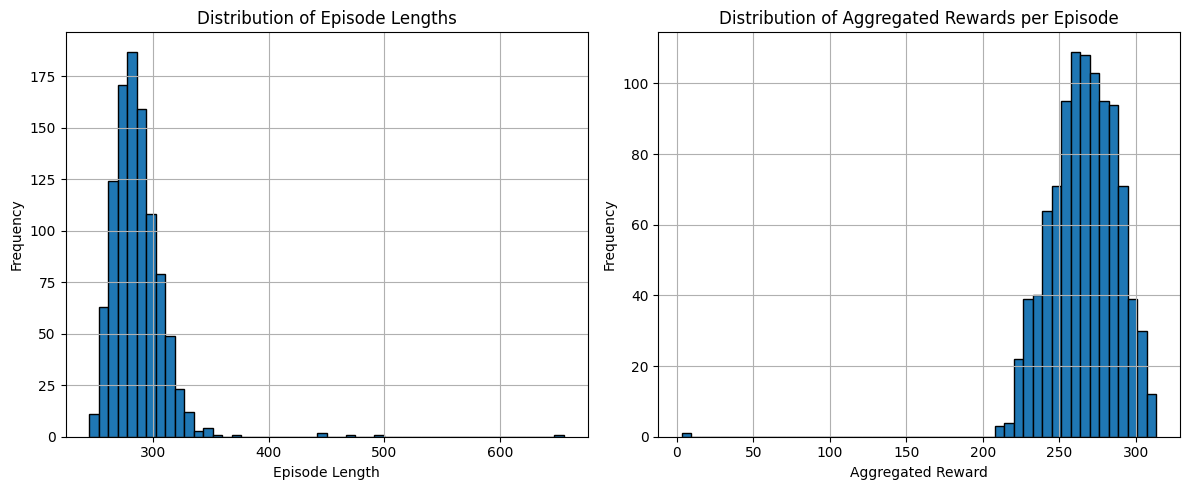

Total number of episodes: 1000
Average episode length: 286.24
Min episode length: 245
Max episode length: 655
Average aggregated reward: 265.91
Min aggregated reward: 3.29
Max aggregated reward: 313.31


{'obs_mean': tensor([-3.8224e-03,  4.5600e-01, -1.2215e-02, -2.1999e-01,  8.3548e-03,
          5.4869e-05,  1.5350e-01,  1.5069e-01]),
 'obs_std': tensor([0.1204, 0.4510, 0.1873, 0.1716, 0.1091, 0.0863, 0.3605, 0.3577]),
 'act_mean': tensor([-0.0279,  0.0534]),
 'act_std': tensor([0.5133, 0.3983])}

In [10]:
horizon = 100
obs_dim = 8
action_dim = 2
dataset_name = "LunarLanderContinuous-v3/ppo-1000-deterministic-v1"
minari_dataset = minari.load_dataset(dataset_id=dataset_name)
minari_dataset_stats = get_dataset_stats(minari_dataset)
visualize_dataset(minari_dataset)
minari_dataset_stats

## Data Preprocessing
Our dataset is made of 1000 episodes, with each episode containing a variable number of timsteps.
This section is used to create chunks of trajectories with the specified horizon length.
1. Normalization and Unnormalization: We need to normalize the chunks before training and unnormalize them after training to get the correct trajectories.
2. The collate function is used to pad the sequence to the same length within a batch when we load it using a DataLoader.

In [ ]:
def visualize_chunk(ax, chunk, color, x_limits=(-0.4, 0.4), y_limits=(-0.2, 1.5), mode='line'):
    x = chunk[:, 0].cpu().numpy()
    y = chunk[:, 1].cpu().numpy()
    if mode == 'line':
        ax.plot(x, y, linestyle='-', color=color, alpha=0.7)
    elif mode == 'scatter':
        ax.scatter(x, y, color=color, alpha=0.7)
    ax.set_xlim(*x_limits)
    ax.set_ylim(*y_limits)
    ax.grid(True)

## Trajectory Visualization from Expert Dataset

Visualing random chunks from each batch...


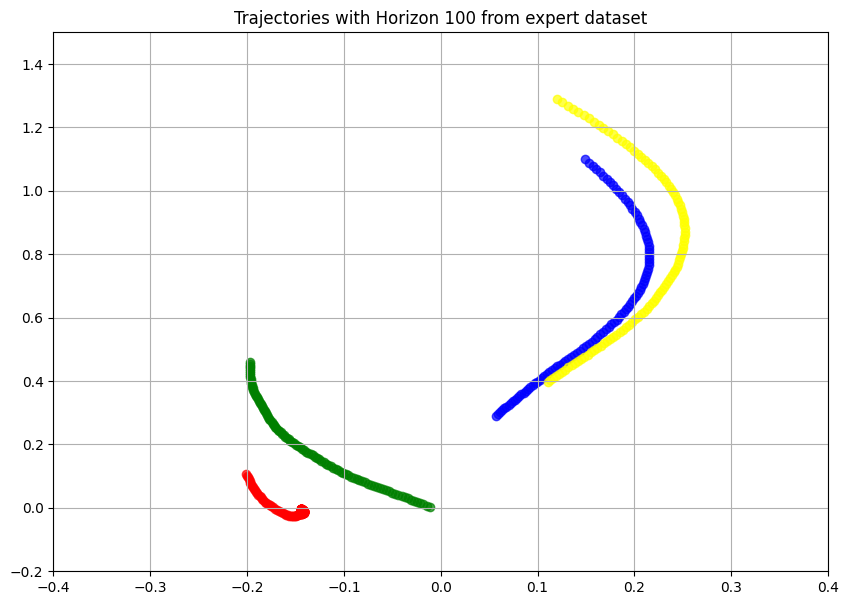

In [7]:
dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'Trajectories with Horizon {horizon} from expert dataset')
print("Visualing random chunks from each batch...")
colors = ['red', 'green', 'blue', 'yellow']
for idx, batch in enumerate(dataloader):
    processed_chunks = create_trajectory_chunks(batch, horizon)
    # uncomment to visualize normalized chunks
    # normalized_chunks = create_normalized_chunks(batch, horizon, minari_dataset_stats)
    random_chunk = random.choice(processed_chunks)
    assert random_chunk.shape == (horizon * (obs_dim + action_dim),)
    random_chunk = random_chunk.reshape(horizon, obs_dim + action_dim)
    expert_obs = random_chunk[:, :obs_dim]
    visualize_chunk(ax, expert_obs, color=colors[idx % len(colors)], mode="scatter")

# Training

## Model Architecture
Let's start with a basic MLP.

In [8]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x


class MLP(nn.Module):
    def __init__(self, input_dim: int, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()

        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim + time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)

        return output.reshape(*sz)
    
class TemporalCNN(nn.Module):
    """
    A 1D Convolutional Neural Network designed to process trajectory data.
    It replaces the MLP to better capture time-based patterns.
    """
    def __init__(
        self,
        horizon: int,
        transition_dim: int, # This is obs_dim + action_dim
        hidden_dim: int = 128
    ):
        super().__init__()
        self.horizon = horizon
        self.transition_dim = transition_dim
        self.hidden_dim = hidden_dim

        # The time `t` will be concatenated as an extra channel.
        # So, input channels = transition_dim + 1 (for time)
        input_channels = transition_dim + 1

        # A simple stack of 1D convolutional blocks.
        # `padding='same'` ensures the sequence length (horizon) doesn't change.
        self.main = nn.Sequential(
            # First block: maps input channels to hidden dimension
            nn.Conv1d(in_channels=input_channels, out_channels=hidden_dim, kernel_size=5, padding='same'),
            Swish(),
            
            # Second block: operates in the hidden dimension
            nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=5, padding='same'),
            Swish(),
            
            # Third block
            nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=5, padding='same'),
            Swish(),
            
            # Final layer: maps back to the original transition dimension
            nn.Conv1d(in_channels=hidden_dim, out_channels=transition_dim, kernel_size=5, padding='same'),
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        """
        Forward pass for the 1D CNN.
        
        Args:
            x (Tensor): The trajectory data, expected in a flattened shape of (batch_size, horizon * transition_dim).
            t (Tensor): The time step, shape (batch_size,).
        
        Returns:
            Tensor: The predicted velocity, with the same shape as the input x.
        """
        # 1. Reshape the flattened input `x` into a sequential format.
        # Shape goes from (batch, horizon * transition_dim) to (batch, transition_dim, horizon).
        # PyTorch's Conv1d expects (batch, channels, length).
        x_reshaped = x.view(-1, self.horizon, self.transition_dim).permute(0, 2, 1)

        # 2. Prepare the time tensor `t`.
        # We need to give the time information to every step in the sequence.
        # We expand `t` to match the shape of the trajectory.
        t_expanded = t.view(-1, 1, 1).expand(-1, 1, self.horizon) # Shape: (batch, 1, horizon)

        # 3. Concatenate time as an additional channel.
        # Input to the network will have shape (batch, transition_dim + 1, horizon).
        h = torch.cat([x_reshaped, t_expanded], dim=1)

        # 4. Pass through the convolutional network.
        # The output will have shape (batch, transition_dim, horizon).
        output_reshaped = self.main(h)

        # 5. Flatten the output back to the original shape.
        # Shape goes from (batch, transition_dim, horizon) back to (batch, horizon * transition_dim).
        output_flat = output_reshaped.permute(0, 2, 1).reshape(x.shape)
        
        return output_flat

## Sanity Check by Overfitting ✅
Let's do a sanity check first on one chunk of the dataset with horizon length 10.

In [83]:
from src.utils.loggers import WandBLogger

# training parameters
horizon = 10
input_dim = (obs_dim + action_dim) * horizon
dataloader = DataLoader(
    minari_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
batch = next(iter(dataloader))
normalized_chunks = create_normalized_chunks(batch, horizon, minari_dataset_stats)
expert_chunk_to_overfit = normalized_chunks[0].to(device)
assert expert_chunk_to_overfit.shape == (horizon * (obs_dim + action_dim),)

# hyperparameters
lr = 1e-4
num_epochs = 1000000
print_every = 100
hidden_dim = 256

config = {
    "horizon": horizon,
    "action_dim": action_dim,
    "obs_dim": obs_dim,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_epochs": num_epochs,
    "lr": lr,
}

logger = WandBLogger(config=config)
vf = MLP(input_dim=input_dim, time_dim=1, hidden_dim=hidden_dim).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim = torch.optim.Adam(vf.parameters(), lr=lr)

print("Overfitting to a single chunk...")
running_loss = 0.0
for i in range(num_epochs):
    optim.zero_grad()

    x_1 = expert_chunk_to_overfit.unsqueeze(0)
    x_0 = torch.randn_like(x_1).to(device)
    t = torch.rand(x_1.shape[0]).to(device)

    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    predicted_velocity = vf(path_sample.x_t, path_sample.t)
    loss = torch.pow(predicted_velocity - path_sample.dx_t, 2).mean()

    loss.backward()
    optim.step()

    running_loss += loss.item()
    if (i + 1) % print_every == 0:
        avg_loss = running_loss / print_every
        print(f"Iteration {i+1:6d}: Avg Loss = {avg_loss:8.5f}")
        logger.log({"avg_loss": avg_loss})
        running_loss = 0.0

avg_loss,████▇▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁
avg_loss,0.47464


Overfitting to a single chunk...
Iteration    100: Avg Loss =  2.49297
Iteration    200: Avg Loss =  1.42179
Iteration    300: Avg Loss =  1.19187
Iteration    400: Avg Loss =  1.12259
Iteration    500: Avg Loss =  1.07674
Iteration    600: Avg Loss =  0.99779
Iteration    700: Avg Loss =  1.04858
Iteration    800: Avg Loss =  1.03489
Iteration    900: Avg Loss =  1.02929
Iteration   1000: Avg Loss =  1.05062
Iteration   1100: Avg Loss =  1.06307
Iteration   1200: Avg Loss =  0.99657
Iteration   1300: Avg Loss =  1.02206
Iteration   1400: Avg Loss =  1.01728
Iteration   1500: Avg Loss =  1.03604
Iteration   1600: Avg Loss =  0.99238
Iteration   1700: Avg Loss =  1.03139
Iteration   1800: Avg Loss =  1.02728
Iteration   1900: Avg Loss =  1.02039
Iteration   2000: Avg Loss =  1.01020
Iteration   2100: Avg Loss =  1.02218
Iteration   2200: Avg Loss =  1.00735
Iteration   2300: Avg Loss =  0.98548
Iteration   2400: Avg Loss =  1.00875
Iteration   2500: Avg Loss =  1.02233
Iteration   2600:

## Sanity Check with Only Observations 👀

In [8]:
def get_xy_dataset_stats(dataset):
    """Computes mean and std for ONLY the X and Y dimensions."""
    print("Calculating X,Y dataset statistics...")
    loader = DataLoader(dataset, batch_size=512, shuffle=False, collate_fn=collate_fn)
    all_obs = []
    for batch in loader:
        for i in range(batch['observations'].shape[0]):
            length = batch['episode_lengths'][i]
            all_obs.append(batch['observations'][i, :length, :2]) # Slice for only X and Y

    flat_obs = torch.cat(all_obs, dim=0)
    stats = {"xy_mean": torch.mean(flat_obs, dim=0), "xy_std": torch.std(flat_obs, dim=0)}
    stats["xy_std"][stats["xy_std"] < 1e-6] = 1e-6
    print("Statistics calculation complete.")
    return stats

def create_xy_chunks(batch, horizon, stats):
    """Creates normalized, flattened chunks of ONLY X,Y coordinates."""
    xy_mean, xy_std = stats['xy_mean'], stats['xy_std']
    all_chunks = []
    for i in range(batch['observations'].shape[0]):
        # We only need the first 2 columns (x, y) from observations
        obs_xy = batch['observations'][i, :, :2]
        length = batch['episode_lengths'][i]
        
        if length < horizon: continue
        for start_idx in range(length - horizon + 1):
            end_idx = start_idx + horizon
            xy_chunk = obs_xy[start_idx:end_idx]
            xy_chunk = xy_chunk.to(xy_mean.device)
    
            norm_xy_chunk = (xy_chunk - xy_mean) / xy_std
            all_chunks.append(norm_xy_chunk.flatten())
            
    if not all_chunks: return None
    return torch.stack(all_chunks)

def unnormalize_xy_trajectory(norm_xy_chunk, stats, horizon):
    """Un-normalizes an X,Y-only trajectory chunk."""
    xy_mean, xy_std = stats['xy_mean'], stats['xy_std']
    reshaped_chunk = norm_xy_chunk.reshape(horizon, 2) # Reshape to (horizon, 2)
    unnorm_xy = (reshaped_chunk * xy_std) + xy_mean
    return unnorm_xy

Calculating X,Y dataset statistics...
Statistics calculation complete.
{'xy_mean': tensor([-0.0262,  0.4665], device='cuda:0'), 'xy_std': tensor([0.1075, 0.4694], device='cuda:0')}


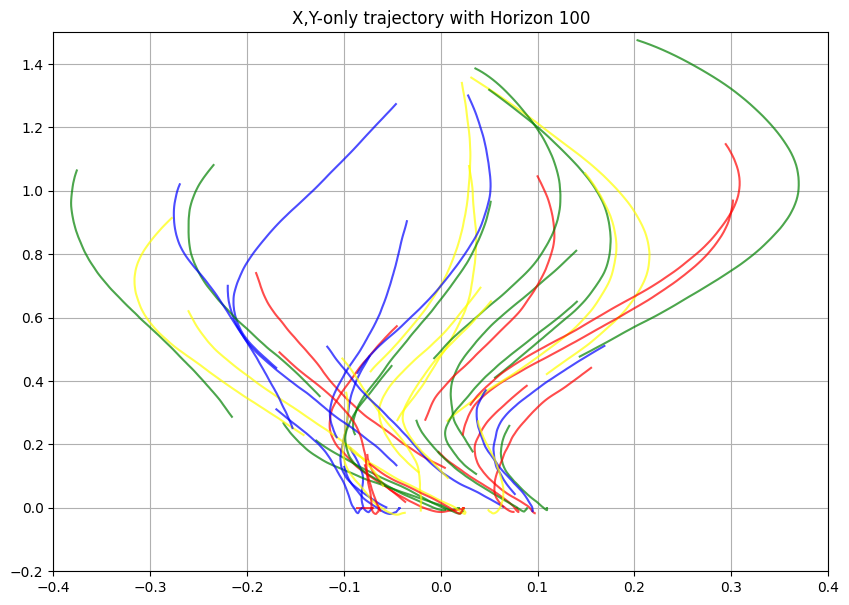

In [ ]:
# load the dataset and compute stats
batch_size = 20
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'X,Y-only trajectories with Horizon {horizon}')
colors = ['red', 'green', 'blue', 'yellow']
minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
dataset_stats = get_xy_dataset_stats(minari_dataset)
for k, v in dataset_stats.items(): dataset_stats[k] = v.to(device)
dataloader = DataLoader(minari_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
print(dataset_stats)
for idx, batch in enumerate(dataloader):
    processed_chunks = create_xy_chunks(batch, horizon, dataset_stats)
    random_chunk = random.choice(processed_chunks)
    assert random_chunk.shape == (horizon * 2,)
    random_chunk = random_chunk.reshape(horizon, 2)
    # Unnormalize the chunk for visualization
    unnorm_xy = unnormalize_xy_trajectory(random_chunk, dataset_stats, horizon)
    visualize_chunk(ax, unnorm_xy, color=colors[idx % len(colors)], mode='line', obs_dim=2)

In [10]:
# Setup parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
horizon = 100
input_dim = horizon * 2  # just the x and y dimensions
hidden_dim = 256
obs_dim = 2
action_dim = 0

# model parameters
transition_dim = obs_dim + action_dim

# training paraeters
lr = 1e-4
num_epochs = 100
print_every = 10
config = {
    "horizon": horizon,
    "obs_dim": 2,
    "action_dim": 0,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "lr": lr,
    "num_epochs": num_epochs
}

# Initialize model and optimizer
logger = WandBLogger(config=config)
# vf = MLP(input_dim=input_dim, time_dim=1, hidden_dim=hidden_dim).to(device)
vf = TemporalCNN(horizon=horizon, transition_dim=transition_dim, hidden_dim=hidden_dim).to(device)

path = AffineProbPath(scheduler=CondOTScheduler())
optim = torch.optim.Adam(vf.parameters(), lr=lr)

print("\nStarting X,Y-only sanity check training...")
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    total_chunks = 0
    start_time = time.time()

    for batch in dataloader:
        optim.zero_grad()
    
        x_1 = create_xy_chunks(batch, horizon, dataset_stats)
        if x_1 is None: continue
        x_1 = x_1.to(device)
        x_0 = torch.randn_like(x_1).to(device)
        t = torch.rand(x_1.shape[0]).to(device)

        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        predicted_velocity = vf(path_sample.x_t, path_sample.t)
        loss = torch.pow(predicted_velocity - path_sample.dx_t, 2).mean()

        loss.backward()
        optim.step()
        total_epoch_loss += loss.item()
        total_chunks += 1

    avg_epoch_loss = total_epoch_loss / total_chunks if total_chunks > 0 else 0
    logger.log({"avg_epoch_loss": avg_epoch_loss})
    if (epoch + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(f"| Epoch {epoch+1:6d} | {elapsed:.2f} s/epoch | Loss {avg_epoch_loss:8.5f} ")
        start_time = time.time()
print("X,Y-only sanity check training complete.")


wandb: Currently logged in as: tsufanglu to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Starting X,Y-only sanity check training...
| Epoch     10 | 28.07 s/epoch | Loss  0.46197 
| Epoch     20 | 27.44 s/epoch | Loss  0.41132 
| Epoch     30 | 28.00 s/epoch | Loss  0.37866 
| Epoch     40 | 29.53 s/epoch | Loss  0.36343 
| Epoch     50 | 26.90 s/epoch | Loss  0.35387 
| Epoch     60 | 29.07 s/epoch | Loss  0.35104 
| Epoch     70 | 24.17 s/epoch | Loss  0.34431 
| Epoch     80 | 30.67 s/epoch | Loss  0.34303 
| Epoch     90 | 33.47 s/epoch | Loss  0.33873 
| Epoch    100 | 33.84 s/epoch | Loss  0.34165 
X,Y-only sanity check training complete.


In [ ]:
# # --- 3. Evaluation ---
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)
step_size = 0.05
batch_size = 1 
T = torch.linspace(0, 1, 10)  # sample times
T = T.to(device=device)
solver = ODESolver(velocity_model=wrapped_vf)


x_init = torch.randn((1, input_dim), dtype=torch.float32, device=device)
sol = solver.sample(x_init=x_init, T=T, step_size=step_size, batch_size=batch_size)
generated_norm_chunk = sol[-1].squeeze(0).detach()
generated_xy = unnormalize_xy_trajectory(generated_norm_chunk, dataset_stats, horizon)
generated_xy.shape


torch.Size([100, 2])

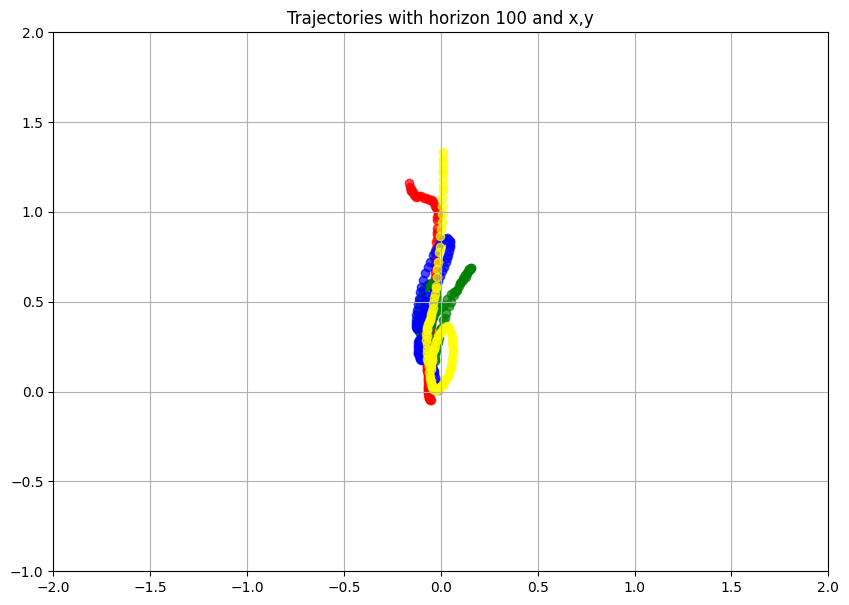

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'Trajectories with horizon {horizon} and x,y')
colors = ['red', 'green', 'blue', 'yellow']

# visulizing trajectories
for _ in range(4):
    x_init = torch.randn((1, input_dim), dtype=torch.float32, device=device)
    sol = solver.sample(x_init=x_init, T=T, step_size=step_size, batch_size=batch_size)
    generated_norm_chunk = sol[-1].squeeze(0).detach()
    generated_xy = unnormalize_xy_trajectory(generated_norm_chunk, dataset_stats, horizon)
    generated_xy.shape
    assert generated_xy.shape == (horizon, 2)
    visualize_chunk(ax, generated_xy, color=colors[_ % len(colors)],
                    x_limits=(-2, 2), y_limits=(-1, 2), mode='scatter', obs_dim=2)

This shows that even if we only model x and y, our generated observations still lack spatial coherence!

## Actual Training 🏋️
Sanity test passed. Let's go ahead and train the model on the entire dataset.

In [41]:
env = minari_dataset.recover_environment()
horizon = 100
action_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
input_dim = (obs_dim + action_dim) * horizon
transition_dim = obs_dim + action_dim
minari_dataset_stats = get_dataset_stats(minari_dataset)


print(f"Horizon: {horizon}")
print(f"Action Dim: {action_dim}")
print(f"Observation Dim: {obs_dim}")
print(f"Input Dim: {input_dim}")
print("Dataset Stats:")
for k, v in minari_dataset_stats.items():
    print(f"  {k}: {v}")

# Training params
lr = 0.001
num_epochs = 1000
print_every = 10
hidden_dim = 256
batch_size = 32

dataloader = DataLoader(minari_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

config = {
    "horizon": horizon,
    "action_dim": action_dim,
    "obs_dim": obs_dim,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "lr": lr
}

logger = WandBLogger(config = config)
# vf = MLP(input_dim=input_dim, time_dim=1, hidden_dim=hidden_dim).to(device)
vf = TemporalCNN(horizon=horizon, transition_dim=transition_dim, hidden_dim=hidden_dim).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim = torch.optim.Adam(vf.parameters(), lr=lr)

print("Starting training...")
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    total_chunks = 0
    start_time = time.time()

    for batch in dataloader:
        optim.zero_grad()
        
        x_1 = create_normalized_chunks(batch, horizon, minari_dataset_stats)
        if x_1 is None:
            continue
        x_1 = x_1.to(device)
        x_0 = torch.randn_like(x_1).to(device)
        t = torch.rand(x_1.shape[0]).to(device)

        # 3. Forward pass and Loss
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        predicted_velocity = vf(path_sample.x_t, path_sample.t)
        loss = torch.pow(predicted_velocity - path_sample.dx_t, 2).mean()

        # 4. Backward pass and Optimize
        loss.backward()
        optim.step()
        total_epoch_loss += loss.item()
        total_chunks += 1

    avg_epoch_loss = total_epoch_loss / total_chunks if total_chunks > 0 else 0
    logger.log({"avg_epoch_loss": avg_epoch_loss})
    if (epoch + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(f"| Epoch {epoch+1:6d} | {elapsed:.2f} s/epoch | Loss {avg_epoch_loss:8.5f} ")
        start_time = time.time()
print("Training finished.")

Statistics calculation complete.
Horizon: 100
Action Dim: 2
Observation Dim: 8
Input Dim: 1000
Dataset Stats:
  obs_mean: tensor([-2.6158e-02,  4.6646e-01,  4.3395e-03, -2.2876e-01, -1.2054e-02,
        -6.0773e-05,  2.1673e-01,  2.1720e-01])
  obs_std: tensor([0.1075, 0.4694, 0.1949, 0.1756, 0.1438, 0.1310, 0.4120, 0.4123])
  act_mean: tensor([-0.1251, -0.0706])
  act_std: tensor([0.5542, 0.4226])


avg_epoch_loss,█▃▂▂▁▁▁▁▁▁
avg_epoch_loss,0.34159


Starting training...
| Epoch     10 | 19.58 s/epoch | Loss  0.34275 
| Epoch     20 | 16.45 s/epoch | Loss  0.30806 
| Epoch     30 | 19.77 s/epoch | Loss  0.29116 
| Epoch     40 | 20.91 s/epoch | Loss  0.28088 
| Epoch     50 | 19.91 s/epoch | Loss  0.27525 
| Epoch     60 | 12.70 s/epoch | Loss  0.27061 
| Epoch     70 | 23.75 s/epoch | Loss  0.26491 
| Epoch     80 | 25.15 s/epoch | Loss  0.26366 
| Epoch     90 | 15.80 s/epoch | Loss  0.26093 
| Epoch    100 | 12.85 s/epoch | Loss  0.25855 
| Epoch    110 | 20.36 s/epoch | Loss  0.25625 
| Epoch    120 | 20.02 s/epoch | Loss  0.25879 
| Epoch    130 | 20.02 s/epoch | Loss  0.25547 
| Epoch    140 | 20.32 s/epoch | Loss  0.25559 
| Epoch    150 | 20.21 s/epoch | Loss  0.25131 
| Epoch    160 | 20.50 s/epoch | Loss  0.25142 
| Epoch    170 | 23.30 s/epoch | Loss  0.25287 
| Epoch    180 | 20.10 s/epoch | Loss  0.24981 
| Epoch    190 | 21.82 s/epoch | Loss  0.24848 
| Epoch    200 | 16.83 s/epoch | Loss  0.24802 
| Epoch    210 | 16

## Sampling

In [42]:
# try sampling from trained model...
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)


wrapped_vf = WrappedModel(vf)
step_size = 0.05
batch_size = 1  # batch size
T = torch.linspace(0, 1, 10)  # sample times
T = T.to(device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class


def generate_trajectory():
    x_init = torch.randn((batch_size, input_dim), dtype=torch.float32, device=device)
    sol = solver.sample(
        time_grid=T,
        x_init=x_init,
        method="midpoint",
        step_size=step_size,
        return_intermediates=True,
    )
    final_trajectory = sol[-1].reshape(horizon, obs_dim + action_dim)
    
    obs, act = unnormalize_trajectory(
        final_trajectory.flatten(), minari_dataset_stats, horizon, obs_dim, action_dim
    )
    return obs, act


obs, act = generate_trajectory()
obs

tensor([[-1.5742e-01,  3.8599e-01,  2.6043e-01, -2.8594e-01, -4.0464e-02,
          7.3215e-02, -1.1672e-03, -1.4573e-04],
        [-1.5326e-01,  3.7534e-01,  2.6284e-01, -2.8777e-01, -3.5773e-02,
          7.2318e-02,  4.5602e-04, -4.4707e-03],
        [-1.4984e-01,  3.7528e-01,  2.5374e-01, -2.7316e-01, -3.2678e-02,
          6.2251e-02, -5.7924e-03,  2.1770e-03],
        [-1.4529e-01,  3.6631e-01,  2.5697e-01, -2.5580e-01, -2.9805e-02,
          6.4183e-02, -1.6775e-03,  1.2517e-03],
        [-1.4149e-01,  3.6277e-01,  2.5472e-01, -2.6045e-01, -2.7855e-02,
          5.9893e-02,  1.2641e-03,  2.7673e-03],
        [-1.3636e-01,  3.5292e-01,  2.6154e-01, -2.7068e-01, -2.6397e-02,
          6.5916e-02, -1.3854e-04,  6.7311e-03],
        [-1.3171e-01,  3.4590e-01,  2.6622e-01, -2.5871e-01, -2.2881e-02,
          6.9262e-02, -1.5570e-03, -2.4689e-03],
        [-1.2528e-01,  3.3936e-01,  2.6600e-01, -2.4528e-01, -2.0248e-02,
          6.5171e-02, -1.5657e-03, -2.3178e-03],
        [-1.1944

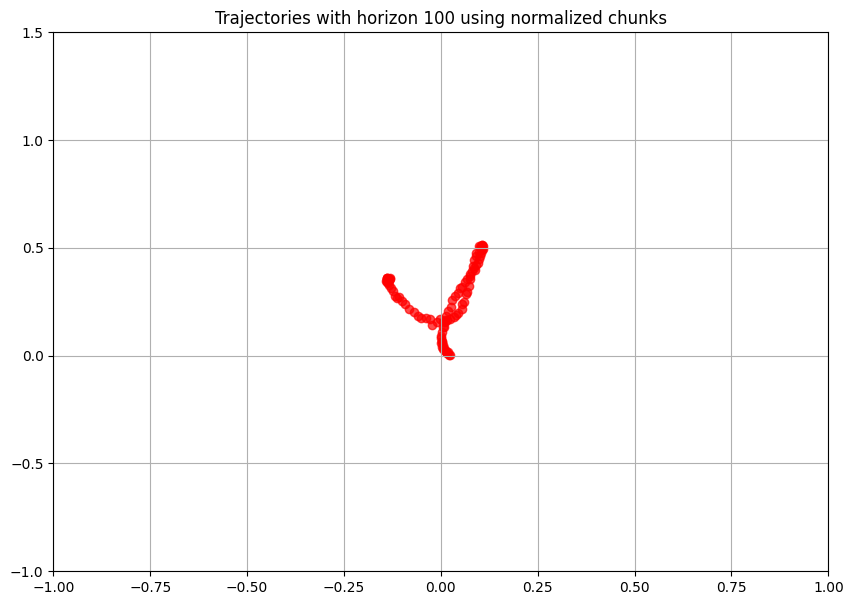

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'Trajectories with horizon {horizon} using normalized chunks')

# visulizing trajectories
for _ in range(1):
    colors = ['blue', 'red', 'green', 'yellow']
    observations, actions = generate_trajectory()
    assert observations.shape == (horizon, obs_dim)
    visualize_chunk(ax, observations, color=colors[_ % len(colors)],
                    x_limits=(-1, 1), y_limits=(-1, 1.5), mode='scatter')

# Evaluation

## Our FM Model vs. Random Policy

In [46]:
num_eval_episodes = 100
env = minari_dataset.recover_environment(eval_env = True)
model_rewards = []
random_rewards = []
for eps in range(num_eval_episodes):
    obs, _ = env.reset()
    total_rew = 0
    obs, actions = generate_trajectory()
    for i in range(horizon):
        action = actions[i].cpu().numpy()
        obs, rew, terminated, truncated, info = env.step(action)
        total_rew += rew
        if terminated or truncated:
            break
    model_rewards.append(total_rew)

    env.reset()
    total_rew_random = 0
    for i in range(horizon):
        action = env.action_space.sample()
        obs, rew, terminated, truncated, info = env.step(action)
        total_rew_random += rew
        if terminated or truncated:
            break
    random_rewards.append(total_rew_random)
    if (eps + 1) % 10 == 0:
        print(f"Finished episode {eps + 1}/{num_eval_episodes} - Model Reward: {total_rew}, Random Reward: {total_rew_random}")
env.close()
print("Evaluation finished.")
avg_model_reward = np.mean(model_rewards)
avg_random_reward = np.mean(random_rewards)
print(f"Average Model Reward: {avg_model_reward:.2f}")
print(f"Average Random Reward: {avg_random_reward:.2f}")

Finished episode 10/100 - Model Reward: -371.89277369416544, Random Reward: -92.46130262607295
Finished episode 20/100 - Model Reward: -277.28568425621285, Random Reward: -31.2531181221821
Finished episode 30/100 - Model Reward: 5.478086502783867, Random Reward: -47.82660137635
Finished episode 40/100 - Model Reward: 16.148161272374708, Random Reward: 0.011294776692071684
Finished episode 50/100 - Model Reward: -265.1868150693196, Random Reward: -167.12258498334907
Finished episode 60/100 - Model Reward: -72.22811914673734, Random Reward: -53.86113515430068
Finished episode 70/100 - Model Reward: -50.08090682573335, Random Reward: -17.20104525239654
Finished episode 80/100 - Model Reward: -300.592711023066, Random Reward: 24.640565647030883
Finished episode 90/100 - Model Reward: -245.07374729255469, Random Reward: -45.7095963757094
Finished episode 100/100 - Model Reward: -357.8214852677325, Random Reward: -169.9221262914958
Evaluation finished.
Average Model Reward: -202.71
Average R

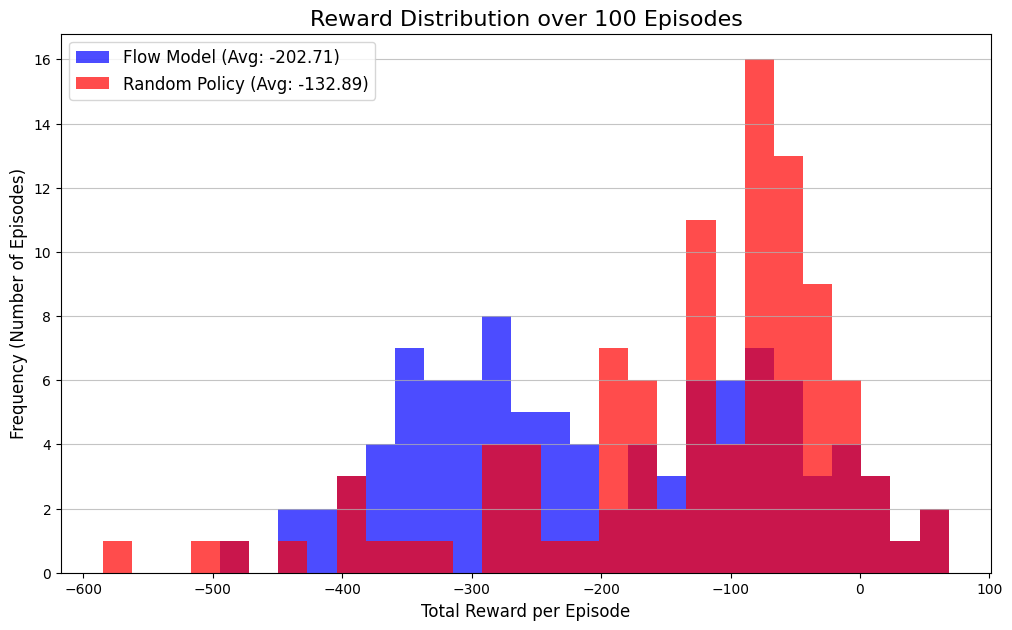

In [48]:
plt.figure(figsize=(12, 7))
# Use a shared range for the bins to make the comparison fair
bins = np.linspace(min(min(model_rewards), min(random_rewards)), max(max(model_rewards), max(random_rewards)), 30)

plt.hist(model_rewards, bins=bins, alpha=0.7, label=f'Flow Model (Avg: {avg_model_reward:.2f})', color='blue')
plt.hist(random_rewards, bins=bins, alpha=0.7, label=f'Random Policy (Avg: {avg_random_reward:.2f})', color='red')

plt.title(f'Reward Distribution over {num_eval_episodes} Episodes', fontsize=16)
plt.xlabel("Total Reward per Episode", fontsize=12)
plt.ylabel("Frequency (Number of Episodes)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

## Rendering the Trajectory

In [62]:

minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
env = minari_dataset.recover_environment(eval_env=True, render_mode="human")

obs, _ = env.reset()
total_rew_random = 0
obs, actions = generate_trajectory()
total_rew = 0
for i in range(horizon):
    action = actions[i].cpu().numpy()
    obs, rew, terminated, truncated, info = env.step(action)
    total_rew += rew
    if terminated or truncated:
        break
env.close()